In [1]:
import torch
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch.nn import functional as F
import torchvision.transforms as transforms
from torch.functional import Tensor
from torch import nn 

In [2]:
MASK_PATH = "/content/drive/MyDrive/Colab Notebooks/data/set-lipstick-original/mask"
IMG_PATH = "/content/drive/MyDrive/Colab Notebooks/data/set-lipstick-original/720p"
LIST_PATH = "/content/drive/MyDrive/Colab Notebooks/data/set-lipstick-original/list.csv"

In [3]:
to_tensor = transforms.ToTensor()

In [4]:
df = pd.read_csv(LIST_PATH)
df = df.head(5000) # беру только 5000 строк, тк обучение на полном датасете и без предобученной модели займет 4+ часа

In [ ]:
#create imgs 'list'
img_set = set(os.listdir(MASK_PATH))
img_set

In [8]:
# from mask00017744.png to 00017744
img_set = set(''.join(filter(lambda x: x.isdigit(), i)) for i in img_set)

In [9]:
#repeat for masks
masks_set = set(os.listdir(MASK_PATH))
masks_set = set(''.join(filter(lambda x: x.isdigit(), i)) for i in masks_set)

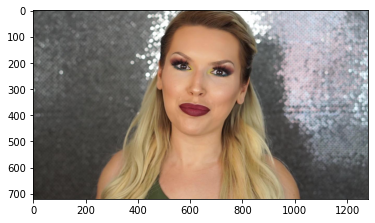

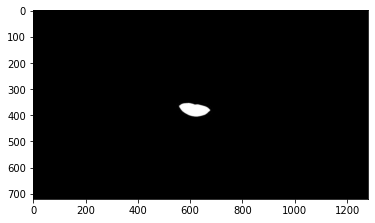

In [32]:
#check mask and img
img_path = os.path.join(IMG_PATH, df.iloc[3]['filename'])
mask_path = os.path.join(MASK_PATH, df.iloc[3]['mask'])

img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_RGB2BGR)
mask = cv2.imread(mask_path)[:, :, 1]

plt.imshow(img)
plt.show()

plt.imshow(mask, cmap='gray')
plt.show()

In [11]:
class SelfLipsDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
    
    def __getitem__(self, idx):
        data = self.df.iloc[idx]
        
        img_path = os.path.join(IMG_PATH, data['filename'])
        mask_path = os.path.join(MASK_PATH, data['mask'])
        
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_RGB2BGR)
        mask = cv2.imread(mask_path)#[:, :, 1]
        
        if self.transform:
            img, mask = self.transform(img, mask)
            return img, mask
    
    def __len__(self):
        return len(self.df)


In [12]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, logits, targets):
        smooth = 1
        num = targets.size(0)
        probs = logits
        m1 = probs.reshape(num, -1)
        m2 = targets.reshape(num, -1)
        intersection = (m1 * m2)

        score = (2. * intersection.sum(1) + smooth) / (m1.sum(1) + m2.sum(1) + smooth)
        score = 1 - (score.sum() / num)
        return score

In [13]:
def mask_img_resize(img, mask, shape = (256, 256)): 
  img, mask = cv2.resize(img, shape), cv2.resize(mask, shape)
  return to_tensor(img), to_tensor(mask)

In [14]:
train_df, test_df = train_test_split(df, test_size = 0.25, random_state = 42)

In [15]:
train_df

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
4884,image00004885.jpg,1280,720,Lips,601,286,682,327,mask00004885.png
3163,image00003164.jpg,1280,720,Lips,645,300,716,355,mask00003164.png
490,image00000491.jpg,1280,720,Lips,643,287,799,386,mask00000491.png
862,image00000863.jpg,1280,720,Lips,664,354,747,405,mask00000863.png
1740,image00001741.jpg,1280,720,Lips,613,293,717,351,mask00001741.png
...,...,...,...,...,...,...,...,...,...
4426,image00004427.jpg,1280,720,Lips,610,277,686,319,mask00004427.png
466,image00000467.jpg,1280,720,Lips,475,390,626,461,mask00000467.png
3092,image00003093.jpg,1280,720,Lips,619,348,719,407,mask00003093.png
3772,image00003773.jpg,1280,720,Lips,590,318,685,364,mask00003773.png


In [16]:
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
train_df

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
0,image00004885.jpg,1280,720,Lips,601,286,682,327,mask00004885.png
1,image00003164.jpg,1280,720,Lips,645,300,716,355,mask00003164.png
2,image00000491.jpg,1280,720,Lips,643,287,799,386,mask00000491.png
3,image00000863.jpg,1280,720,Lips,664,354,747,405,mask00000863.png
4,image00001741.jpg,1280,720,Lips,613,293,717,351,mask00001741.png
...,...,...,...,...,...,...,...,...,...
3745,image00004427.jpg,1280,720,Lips,610,277,686,319,mask00004427.png
3746,image00000467.jpg,1280,720,Lips,475,390,626,461,mask00000467.png
3747,image00003093.jpg,1280,720,Lips,619,348,719,407,mask00003093.png
3748,image00003773.jpg,1280,720,Lips,590,318,685,364,mask00003773.png


In [17]:
train_data = SelfLipsDataset(train_df, transform = mask_img_resize)
test_data = SelfLipsDataset(test_df, transform = mask_img_resize)

In [18]:
train_data_loader = DataLoader(
    train_data,
    batch_size=24,
    shuffle=True
)
test_data_loader = DataLoader(
    test_data,
    batch_size=12,
    shuffle=False
)

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [20]:
!pip install segmentation-models-pytorch

     |████████████████████████████████| 88 kB 3.5 MB/s 
     |████████████████████████████████| 58 kB 6.0 MB/s 
     |████████████████████████████████| 376 kB 32.4 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=4d11eefc9bdc0b90c30705150cce6efb2fbb4bb419f6aceff108e3999afe45d0
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=2b2909d998a683ea454689b98705c4a35abe0872cf371fd54b39c0f1c4f23094
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


In [21]:
import segmentation_models_pytorch as smp

# создание модели
BACKBONE = 'resnet34'
segmodel = smp.Linknet(BACKBONE,activation = 'sigmoid', encoder_depth=5, encoder_weights='imagenet', decoder_use_batchnorm=True, in_channels=3, classes=1).to(device)
preprocess_input = smp.encoders.get_preprocessing_fn(BACKBONE, pretrained='imagenet')

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [22]:
dataset = SelfLipsDataset(df,  transform = mask_img_resize)

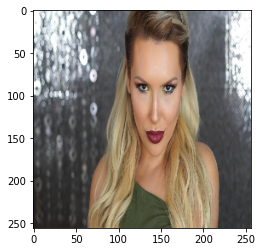

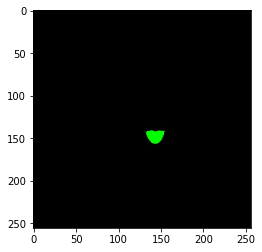

In [23]:
img, mask = dataset[0]

plt.imshow(img.permute(1, 2, 0))
plt.show()

plt.imshow(np.squeeze(mask.permute(1, 2, 0)), cmap='gray')
plt.show()

In [24]:
criterion = smp.utils.losses.DiceLoss()
metrics = [smp.utils.metrics.IoU(),]

optimizer = torch.optim.Adam(params=segmodel.parameters(), lr=0.001)

In [25]:
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    segmodel, 
    loss=criterion, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    segmodel, 
    loss=criterion, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

In [26]:
torch.cuda.is_available()

True

In [27]:
# train model

max_score = 0

for i in range(0, 1):
    print(f'Epoch: {i + 1}')
    train_logs = train_epoch.run(train_data_loader)
    valid_logs = valid_epoch.run(test_data_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(segmodel, './best_model.pth')
        print('Model saved!')

Epoch: 1
valid: 100%|██████████| 105/105 [12:18<00:00,  7.03s/it, dice_loss - 0.3791, iou_score - 0.8518]
Model saved!


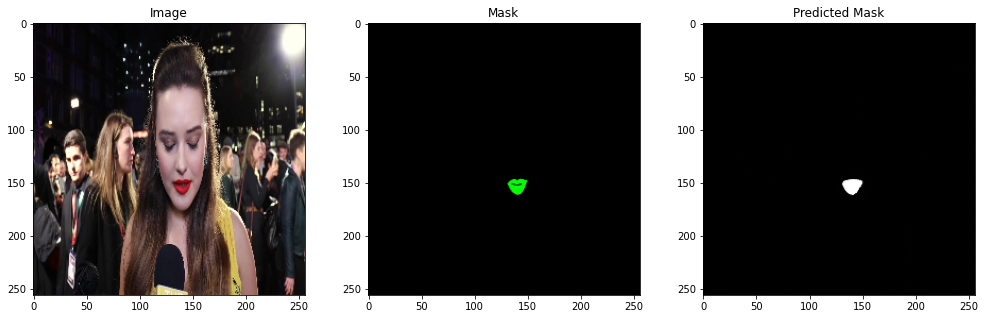

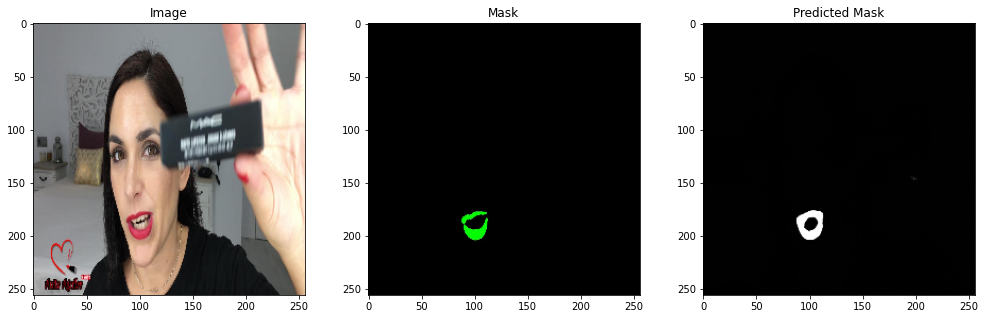

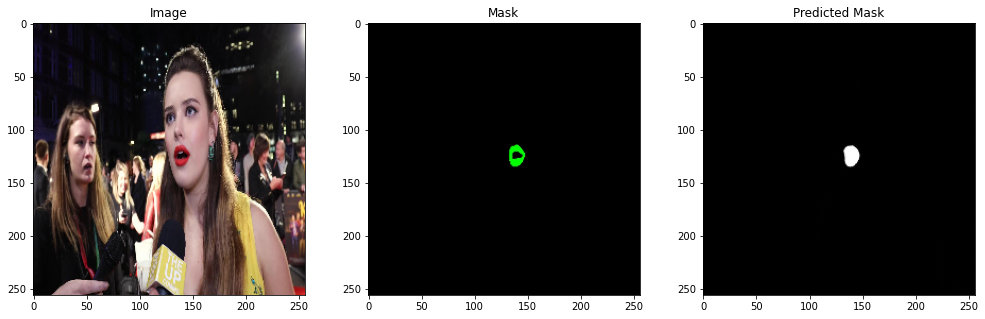

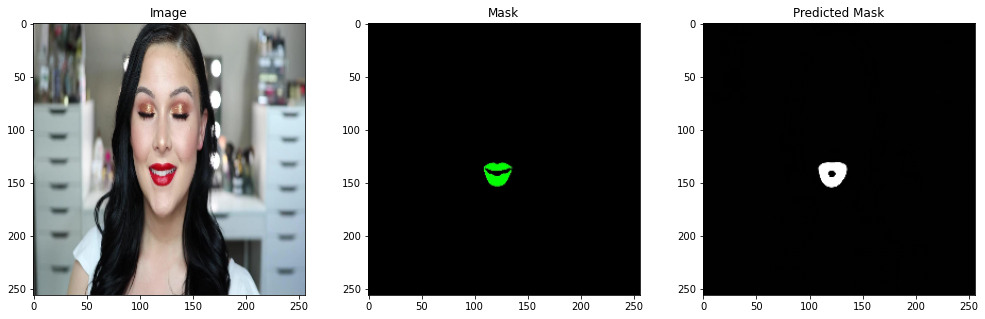

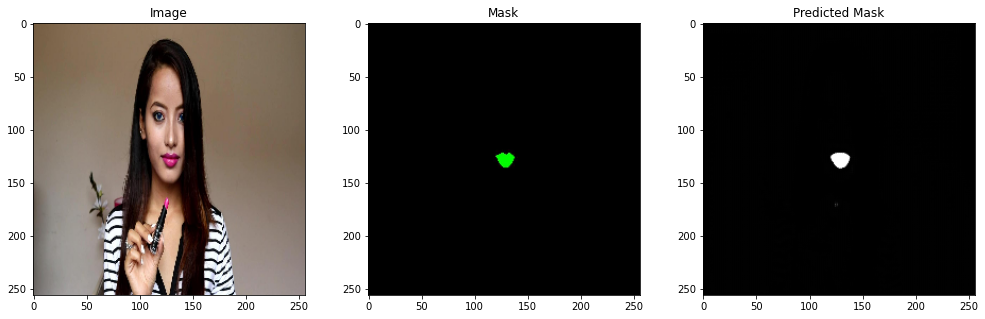

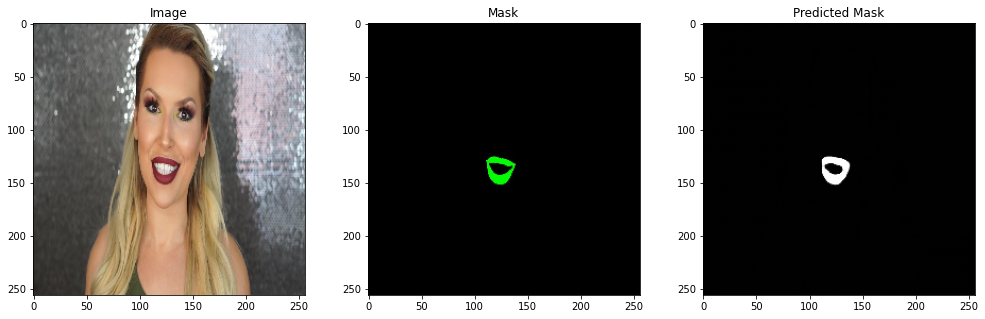

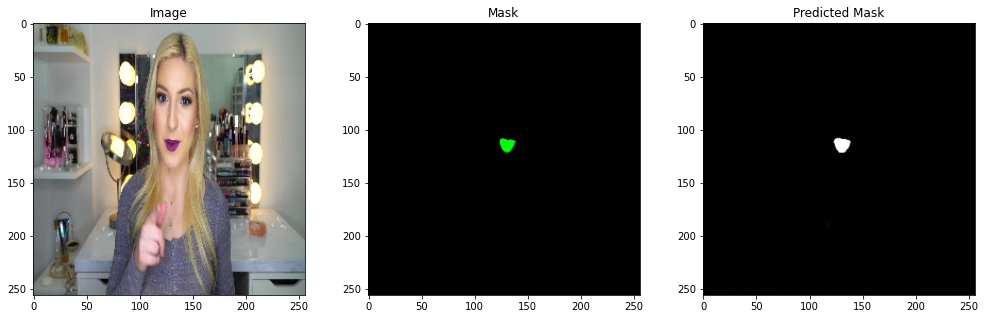

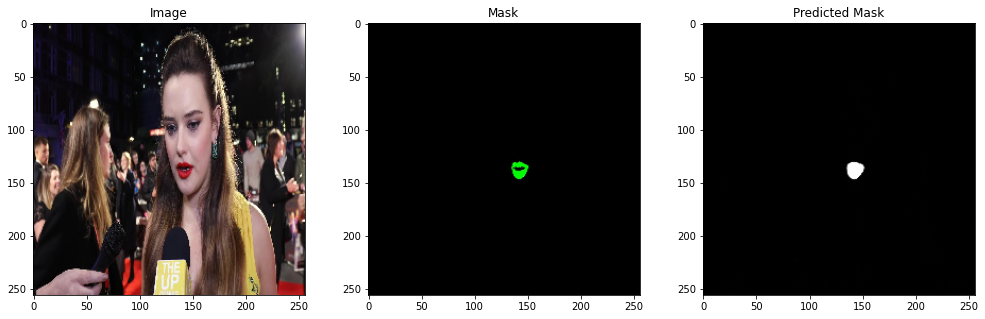

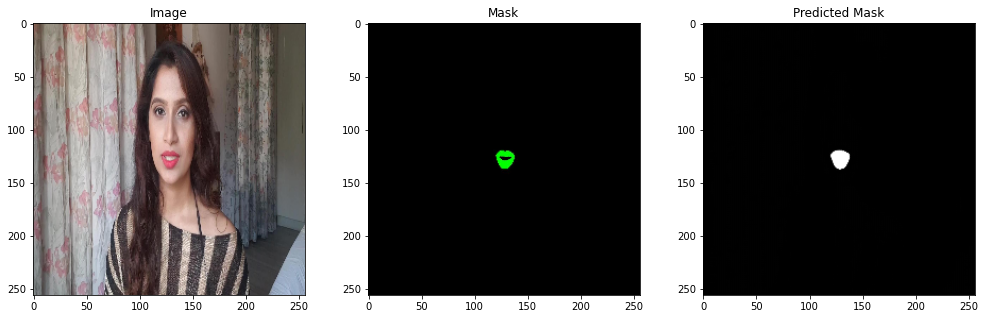

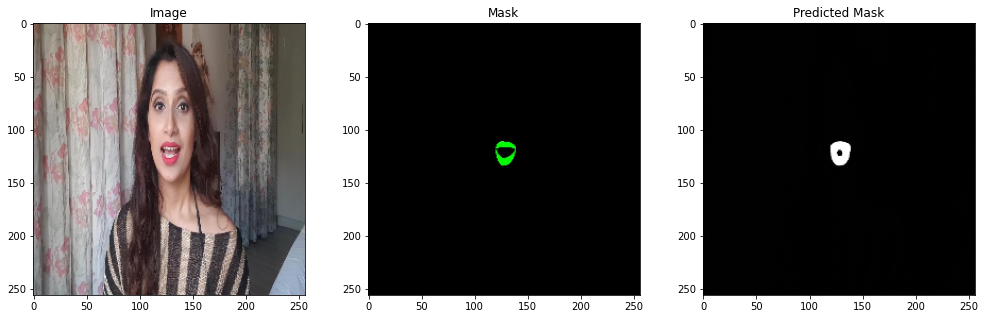

In [31]:
def draw_imgs(img, mask, pred_mask):
    
    fig, ax = plt.subplots(1, 3, figsize=(17, 5))

    ax[0].imshow(img.cpu().permute(1, 2, 0))
    ax[0].set_title('Image')

    ax[1].imshow(mask.cpu().permute(1, 2, 0), cmap='gray')
    ax[1].set_title('Mask')

    ax[2].imshow(np.squeeze(pred_mask.detach().cpu().permute(1, 2, 0)), cmap='gray')
    ax[2].set_title('Predicted Mask')

    plt.show()

indices = np.random.randint(len(test_data), size=10)

segmodel.eval()
with torch.no_grad():
    for idx in indices:
        img, mask = test_data[idx]
        pred_mask = segmodel(img[np.newaxis, :, :, :].to(device))

        draw_imgs(img, mask, pred_mask[0, ...])